<a href="https://colab.research.google.com/github/martinfernandoortiz/geoestadistica_unlp/blob/main/Interpolacion_espacial_clase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Guia de la pràctica 3 - Parte II*

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from joblib import dump, load

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Definimos las funciones que vamos a utilizar:
 - Metodo de inversa distancia (IDW)
 - K nearest neigbors (KNN)
 - Funciones para graficar grillas

In [54]:
def distance_matrix(x0, y0, x1, y1):
    """ Make a distance matrix between pairwise observations.
    Note: from <http://stackoverflow.com/questions/1871536>
    """

    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    # calculate hypotenuse
    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi, power=1):
    """ Simple inverse distance weighted (IDW) interpolation
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """

    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0/(dist+1e-12)**power

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)


def knn(df_coordenadas, model):
    """ K-NN
     Inputs:
     - dataframe con las coordenadas. LA lectura de las mismas
 por parte del modelo tienen la forma [[x1,y1], [x2, y2],...[xn,yn]]
     - modelo predictivo

     Outputs: predicciones del modelo a partir del modelo (valor de zi),
          a partir d elas coordenadas de cada punto de la grilla
    """
    predictions_KNN = model.predict(df_coordenadas.values)
    return predictions_KNN

def plot(x,y,z, grid, Isocontornos = None):
    """ Plot the input points and the result """
    extent = (x.min(), x.max(), y.min(), y.max() )
    plt.figure(figsize=(15,10))
    plt.imshow(grid, extent=extent, cmap='rainbow', interpolation='gaussian')

    if Isocontornos != None:
        plt.contour(grid, extent=extent, levels=Isocontornos, linewidths=1, colors='gray')
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7,s=20)
    plt.colorbar()



def plot(x, y, z, grid, Isocontornos=None, country_boundaries=None):
    """ Plot the input points, result, and country boundaries """
    extent = (x.min(), x.max(), y.min(), y.max())
    plt.figure(figsize=(15, 10))

    # Mostrar la grilla interpolada como una imagen
    plt.imshow(grid, extent=extent, cmap='rainbow', interpolation='gaussian',aspect='auto')

    # Agregar isocontornos si se proporcionan
    if Isocontornos is not None:
        # Personalizar la apariencia de los isocontornos
        plt.contour(grid, extent=extent, levels=Isocontornos, linewidths=1, colors='gray')

    # Mostrar los límites del país como referencia
    if country_boundaries is not None:
        #country_boundaries.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
        country_boundaries.boundary.plot(ax=plt.gca(), color='black', linewidth=1, linestyle='dashed')
    # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=20)

    # Agregar una barra de color para la escala de colores
    plt.colorbar()

***
# *Apertura de  datos*

***

In [3]:
# 1- Abrir la tabla filtrada (resultado final de la Pràctica 1)

df = pd.read_csv('/content/drive/My Drive/datasets_colab/smn_coord.csv')


In [46]:
# Carga de país

# Cargar los límites del país desde un archivo GeoJSON (cambia la ruta al archivo correspondiente)
country_boundaries = gpd.read_file('/content/drive/My Drive/datasets_colab/pais.gpkg')

In [ ]:
#######################
#
#   Retocamos algunos tipo de datos para todos sean float (numeros reales)
#
########################################################3

In [5]:
#######################################
#
#   reemplaza lo que aparece como "S/D" en "cero"
#
###############################################3

df.replace("S/D", 0, inplace = True)
df.replace(np.nan, 0, inplace = True)


In [6]:
df.columns

Index(['fid', '...1', 'Estacion', 'mes', 'lat', 'long', 'Altura_(m)', 'Numero',
       'Temperatura_(C)', 'Temperatura_maxima_(C)', 'Temperatura_minima_(C)',
       'Humedad_relativa_(%)', 'Velocidad_del_Viento_(km/h)',
       'Nubosidad_total_(octavos)', 'Precipitacion_(mm)',
       'Frecuencia_dias_Precipitacion_>0.1_mm'],
      dtype='object')

In [7]:
# transforma todas las columnas, menos 'Unnamed: 0', 'Unnamed: 0.1', 'Estacion', 'mes'
#  en columnas con numeros reales

for col in df.drop(['fid', '...1', 'Estacion', 'mes'], axis = 1):
    df[col] = pd.to_numeric(df[col])

In [22]:
df_filtered = df[['lat', 'long', 'Temperatura_(C)']].dropna()
#df_sin_nan = df['lat','long','Temperatura_(C)'].dropna()


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   fid                                    840 non-null    int64  
 1   ...1                                   840 non-null    int64  
 2   Estacion                               840 non-null    object 
 3   mes                                    840 non-null    object 
 4   lat                                    840 non-null    float64
 5   long                                   840 non-null    float64
 6   Altura_(m)                             840 non-null    int64  
 7   Numero                                 840 non-null    int64  
 8   Temperatura_(C)                        840 non-null    float64
 9   Temperatura_maxima_(C)                 840 non-null    float64
 10  Temperatura_minima_(C)                 840 non-null    float64
 11  Humeda

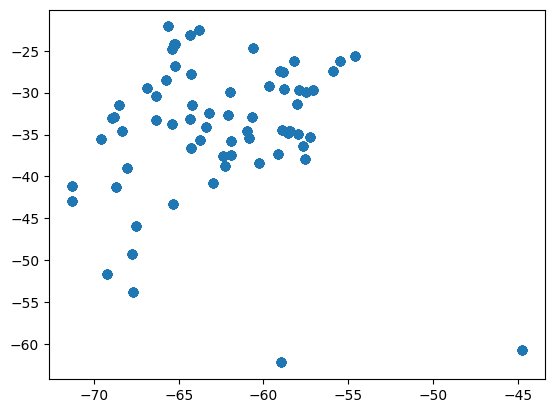

In [24]:
#######################
#
#   Ejemplo: datos de Temperatura media
#
###########################################
y = df_filtered.lat.values
x = df_filtered.long.values
z = df_filtered['Temperatura_(C)'].values
plt.scatter(x,y)

***
# *Armado de la grilla*
***

In [26]:
# size of the grid to interpolate
nx, ny = 100, 100

# generate two arrays of evenly space data between ends of
#  previous arrays
xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.max(), y.min(), ny)

# generate grid
xi, yi = np.meshgrid(xi, yi)

# colapse grid into 1D
xi, yi = xi.flatten(), yi.flatten()

***
# *Aplicaciòn del mètodo IDW*
***

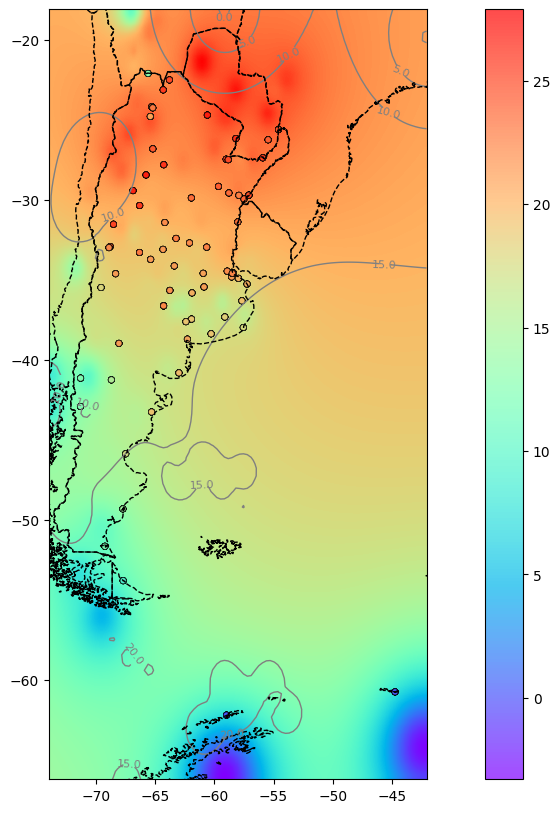

In [64]:

def plot_with_country(x, y, z, grid, Isocontornos=None, country_boundaries=None, margin_scale=0.1):
    """ Plot the input points, result, and country boundaries with a specified margin """

    # Obtener los límites del bounding box de los puntos
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()

    # Calcular el rango del bounding box de los puntos
    x_range = x_max - x_min
    y_range = y_max - y_min

    # Calcular los límites ajustados con un margen del 10%
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range

    plt.figure(figsize=(15, 10))

    # Mostrar la grilla interpolada como una imagen
    plt.imshow(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted), cmap='rainbow', interpolation='gaussian', aspect='auto')

    # Agregar isocontornos si se proporcionan
    if Isocontornos is not None:
        # Personalizar la apariencia de los isocontornos
        contours = plt.contour(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted), levels=Isocontornos, linewidths=1, colors='gray')
        # Agregar etiquetas a los isocontornos
        plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

    # Mostrar los límites del país como referencia sin relleno
    if country_boundaries is not None:
        country_boundaries.boundary.plot(ax=plt.gca(), color='black', linewidth=1, linestyle='dashed')

    # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=20)

    # Agregar una barra de color para la escala de colores
    plt.colorbar()

    # Ajustar los límites del eje según el bounding box ajustado con margen
    plt.xlim(x_min_adjusted, x_max_adjusted)
    plt.ylim(y_min_adjusted, y_max_adjusted)
# Ejemplo de uso
plot_with_country(x, y, z, grid1, Isocontornos=[-10,-5,0,5, 10,15, 20,25,30, 35], country_boundaries=country_boundaries, margin_scale=0.1)
plt.show()

***
# *Aplicaciòn del mètodo KNN*
***

Vamos a proponer un modelo de predicciòn de valores

In [65]:
############################################
#
#     Tomamos la "Temperatura# como ejemplo
#
################################################

coords_temp = df_filtered[['long','lat']].values
value_temp = df_filtered['Temperatura_(C)'].values

############################################
#
#     Separamos en train y test los datos
#
################################################
coords_temp_train, coords_temp_test, value_temp_train, value_temp_test = train_test_split(coords_temp, value_temp, test_size = 0.30, random_state = 32024242)


############################################
#
#  - Definimos la cantidsd de vecinos
#  - Inicializamos el modelo KNN (del tipo regresiòn)
#
################################################
neighbors = 20


knn_regressor = KNeighborsRegressor(n_neighbors = neighbors,
                                    weights = "distance")


############################################
#
#  - Ajustamos el modelo con los datos de entrenamiento "train"
#
#
################################################
knn_regressor.fit(coords_temp_train, value_temp_train)

KNeighborsRegressor(n_neighbors=20, weights='distance')

1. Evaluacion de modelo
2. Prediccion del modelo

In [68]:
# Generate out-of-sample R^2
out_r_squared_knn = knn_regressor.score(coords_temp_test, value_temp_test)
print("KNN out-of-sample r-squared: {}".format(round(out_r_squared_knn, 2)))

#knn_regressor.(coords_temp_test, value_temp_test)

###################################
#
#    Mean_square_error
#
################################################

pred_y = knn_regressor.predict(coords_temp_test)
y = value_temp_test

mse = mean_squared_error(y, pred_y)
print("Mean Squared Error:",mse)


# Predict values for testing dataset
values_temp_test_predict_knn = knn_regressor.predict(coords_temp_test)

KNN out-of-sample r-squared: 0.34
Mean Squared Error: 29.857041610631125


In [74]:
len(xi)
len(yi)

10000

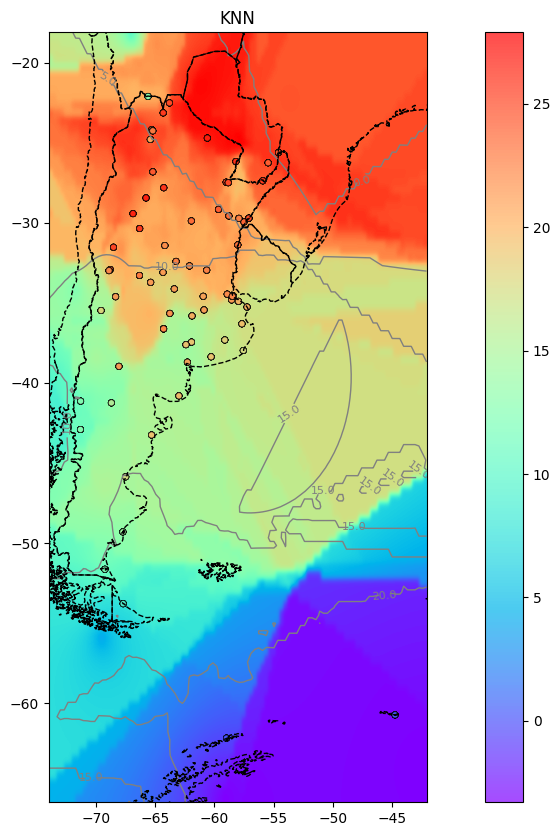

In [77]:
################################################
#
#    - Armado de un dataframe adecuando para introducir
#       las coordenadas de la forma adecuada para el modelo KNN
#
#    - Llamado a la funcion del metodo de interpolacion KNN
#
#   -  Llamaod a la funcion gráfica
#
#########################################################3
dfC= pd.DataFrame(columns = ['x','y'])
dfC['x'] = xi
dfC['y'] = yi


grid1 = knn(dfC, knn_regressor)
grid1 = grid1.reshape((ny, nx))


y = df_filtered.lat.values
x = df_filtered.long.values
z = df_filtered['Temperatura_(C)'].values

plot_with_country(x, y, z, grid1, Isocontornos=[-10,-5,0,5, 10,15, 20,25,30, 35], country_boundaries=country_boundaries, margin_scale=0.1)

#plot(x,y,z, grid1, contornos)
plt.title('KNN')
plt.show()


***
# Guardado del modelo
***

In [ ]:
dump("nombre_interno_del_modelo, 'filename.joblib')

***
# Si quiero abrir el modelo
***

In [ ]:
model = load('filename.joblib')